# Notæ 5

# Automatización de pruebas computacionales

En los notebooks anteriores vimos los fundamentos para generar grafos con el paquete NetworkX, modelar con PLE problemas de optimización en grafos, escribir estos modelos en Python, resolverlos con CPLEX y consultar las soluciones encontradas. Sin embargo, todo este proceso fue bastante "manual", en el sentido de que tuvimos que "tocar" bastante código en todo lo que fuimos haciendo.

El objetivo de este notebook es aprender buenas prácticas para automatizar este proceso. Primero, aprenderemos a crear un dataset, es decir, un directorio que contenga un archivo por cada instancia que estemos interesados en resolver, con algún formato en particular. Segundo, aprenderemos a leer estos archivos, volver a convertirlos en valores que puedan ser interpretados por Python, para luego poder escribir sus correspondientes modelos de PLE y resolverlos. Buscamos que esto último sea independiente del dataset, es decir, que el dataset sea un argumento de entrada a nuestro programa. Tercero, aprenderemos a guardar las salidas de CPLEX en archivos. De esta forma, podemos dejar corriendo pruebas durante horas o días y, al finalizar, podemos revisar los archivos generados y analizar las salidas producidas.

Este proceso será ejemplificado siguiendo como caso de estudio el Problema de Dominación Generalizado (más adelante veremos su definición formal). Dado que este problema es difícil en grafos bipartitos y split, nos parece interesante poder incluir en el dataset instancias con grafos de estas clases. Por lo tanto, antes de empezar a crear el dataset, continuaremos ampliando los contenidos del notebook 4 y aprenderemos a generar algunas clases de grafos nuevas.

## Generación avanzada de grafos (continuación)

En primer lugar, vamos a necesitar todos los generadores de grafos que definimos en el notebook 4. Si bien podríamos copiar todas las definiciones acá, vamos a seguir un enfoque diferente para que el notebook no quede demasiado largo. Ya nos tomamos el trabajo de pasar todas estas definiciones a un archivo <code>generadores.py</code> que lo pueden descargar del siguiente  <a href="https://github.com/maurolucci/taller-cplex/blob/main/generadores.py">link</a>. <b>Guarden este archivo en el mismo directorio donde está este notebook</b> (si siguieron las intrucciones, debería ser en el directorio Taller/). 

Una vez hecho esto, ya podemos importar este archivo, así las funciones allí definidas pueden ser usadas en este notebook. En en este caso, en la importación optamos por ponerle un nombre abreviado <code>gen</code> (como hicimos con networkx y nx).

In [1]:
import generadores as gen

Por ejemplo, podemos generar el grafo de kneser K(5,2):

In [2]:
petersen = gen.generar_kneser(5,2)

También vamos a importar el módulo NetworkX, para tener a disposición sus generadores y funciones built-in. Y también necesitaremos el módulo <code>random</code> (ya veremos para qué).

In [3]:
import networkx as nx
import random

### Grafos bipartitos aleatorios

<b>Definición.</b> Un grafo $G=(V,E)$ es bipartito si $V$ se puede particionar en dos conjuntos $A$ y $B$, es decir, $V = A \cup B$ y $A \cap B = \emptyset$, tales que toda arista conecta un vértice de un conjunto con un vértice del otro, es decir, para todos $a_1,a_2 \in A$ y $b_1,b_2 \in B$, se tiene $a_1a_2, b_1b_2 \not\in E$.

La generación de un grafo bipartito aleatorio $G=(A \cup B, E)$ se puede realizar por medio de los siguientes parámetros:
* Un número natural $nA$ que representa el cardinal de $A$ (primer conjunto de la bipartición).
* Un número natural $nB$ que representa el cardinal de $B$ (segundo conjunto de la bipartición).
* Un número real $p \in [0,1]$ que representa la probabilidad de que un vértice de $A$ y uno de $B$ sean adyacentes.

La idea de la generación es la siguiente. Recorremos cada par de vértices $(a,b)$ con $a \in A$ y $b \in B$ y decidimos si agregamos una arista entre $a$ y $b$ de forma aleatoria. Para ello, generamos un número flotante aleatorio en $[0,1]$ con una distribución uniforme mediante la función <code>random</code> del módulo <code>random</code>. Si el número aleatorio generado es menor a $p$ entonces agregamos la arista. El único cuidado que tenemos que tener es no pisar el nombre de los vértices de $A$ con los de $B$. Por este motivo, etiquetamos a los vértices de $A$ como $\{0,1,\ldots,nA-1\}$ y a los de $B$ como $\{nA,nA+1,\ldots,nB-1\}$.

In [4]:
def generar_bipartito_aleatorio(nA,nB,p):
    G = nx.Graph()
    # Aristas entre A y B
    for a in range(nA):
        for b in range(nB):
            if random.random() < p: # Agregamos arista?
                G.add_edge(a, nA+b)
    return G

Probamos nuestra función y graficamos el grafo resultante. Aprovechamos que NetworkX nos provee la función <code>bipartite_layout(G, A)</code> que nos computa un lindo layout para los vértices. 

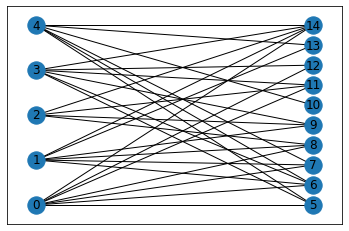

In [5]:
nA = 5
nB = 10
p = 0.5
G = generar_bipartito_aleatorio(nA, nB, p)
nx.draw_networkx(G, pos=nx.bipartite_layout(G, range(nA)))

### Grafos split aleatorios

<b>Definición.</b> Un grafo $G=(V,E)$ es split si $V$ se puede particionar en una clique $K$ y un estable $S$.

La generación de un grafo split aleatorio $G=(K \cup S, E)$ se puede realizar de una forma muy similar a la anterior. Consideraremos los siguientes parámetros:
* Un número natural $nK$ que representa el cardinal de $K$ (clique).
* Un número natural $nS$ que representa el cardinal de $S$ (estable).
* Un número real $p \in [0,1]$ que representa la probabilidad de que un vértice de $K$ y uno de $S$ sean adyacentes.

### &#x1f4bb; Actividad 1. 

Completar la definición de la siguiente función que genera un grafo split aleatorio.

In [6]:
### Espacio para completar la Actividad 1

def generar_split_aleatorio(nK,nS,p):
    G = nx.Graph()
    # COMPLETAR
    return G

### Grafos webs

Queremos hacer un comentario repecto a los grafos webs antes de pasar a armar el dataset. Repasemos su definición.

<b>Definición.</b> Dados $n,m \in \mathbb{N}$ con $n \leq 2m+1$, el grafo web $W^m_n$ es un grafo donde $V(W^m_n) = \{v_0,\ldots,v_{n-1}\}$ y $v_iv_j \in E(W^m_n)$ si y solo si $j \equiv i \pm l\ (mod\ n)$, $l \in \{1,\ldots,m\}$.

También es sabido que $W^m_n$ es isomorfo a $(C_n)^m$, es decir, a la $m$-ésima potencia del ciclo $C_n$. 

El módulo NetworkX ya nos provee la función <code>power(G, k)</code> que permite calcular la $k$-ésima potencia de un grafo $G$. Por lo tanto la generación de grafos webs es trivial.

In [7]:
def generar_web(n,m):
    return nx.power(nx.cycle_graph(n),m)

Ejemplo de uso:

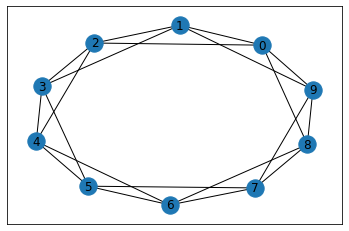

In [8]:
W_10_2 = generar_web(10,2)
nx.draw_networkx(W_10_2)

## Caso de estudio

<b>Definición.</b> Dado un grafo $G=(V,E)$ y dos vectores $k,u \in \mathbb{Z}_+^V$, una función de $(k,u)$-dominación de $G$ es una función $f: V \to \mathbb{Z}_+$ tal que, para todo $v \in V$, $f(v) \leq u_v$ y $f(N[v]) \doteq \sum_{w \in N[v]}f(w) \geq k_v$. 

Vamos a trabajar con el siguente problema.

<b>Problema de Dominación Generalizado (PDG)</b>.<br>
<b>Entrada.</b> Un grafo $G=(V,E)$ y dos vectores $k,u \in \mathbb{Z}_+^V$.<br>
<b>Objetivo.</b> Encontrar una función $f$ de $(k,u)$-dominación de $G$ con mínimo $f(V) \doteq \sum_{v \in V}f(v)$.

Este problema generaliza a muchos problemas de dominación. En particular generaliza a la dominación clásica cuando $u = k = \boldsymbol{1}$.

De forma análoga se puede definir el Problema de Packing Generalizado, más detalles consultar en  <a href="https://www.sciencedirect.com/science/article/pii/S1877050923010220">E. Hinrichsen, G. Nasini, N. Vansteenkiste (2023)</a>. Es interesante mencionar que estos dos problemas son "equivalentes", en el sentido de que una entrada de uno se puede transformar en tiempo polinomial en una entrada del otro, y viceversa. Actualmente las autoras se encuentran estudiando estos problemas.

Una formulación de PLE intuitiva para este problema es la siguiente.

\begin{align*}
\min & \sum_{v \in V} f_v & \\
s.a.\ & \sum_{w \in N[v]} f_w \geq k_v & \forall\ v \in V.\tag{1}\\
& f_v \leq u_v & \forall\ v \in V.\tag{2}\\ 
& f_v \in \mathbb{Z}_+ & \forall\ v \in V.\\
\end{align*}

En Python podemos escribir fácilmente una función que construya y resuelva este modelo. Pero primero importamos los módulos de CPLEX que vamos a necesitar.

In [9]:
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution

Para definir la función, se tienen en cuenta las siguientes consideraciones. 
* Se considera un argumento por cada entrada de PDG. En particular, se elegió representar los vectores $k$ y $u$ con listas de Python. 
* Se agrega un argumento opcional <code>archivo</code> a la función (con un valor <code>None</code> por defecto). Más adelante volveremos a este punto. Por lo pronto, adelantamos que lo usaremos para que CPLEX escriba el log en ese archivo.
* Las variables enteras las agregamos con el método <code>integer_var</code> de la clase <code>Model</code>, que toma como argumento una cota inferior para la variable, una cota superior y el nombre de la variable. Estas cotas hacen que las restricciones (2) puedan ser deducidas por CPLEX y no necesiten ser agregadas al modelo.
* Retornamos el modelo y la solución de CPLEX. Más adelante aprenderemos a manipularlos adecuadamente.

In [10]:
def resolver_PDG(G, k, u, archivo=None):
    """Construye y resuelve el modelo de PLE para el PDG."""
    
    # Inicializamos el modelo 
    modelo = Model(name='dom-gen') 
    
    # Variables
    F = [modelo.integer_var(0, u[v], 'f_' + str(v)) for v in G]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(F[v] for v in G))
    
    # Restricciones (1)
    # Recordar que G.neighbors(v) es la vecindad abierta de v
    for v in G:
        modelo.add_constraint(F[v] + modelo.sum(F[w] for w in G.neighbors(v)) >= k[v])

    # Resolvemos el modelo
    sol = modelo.solve(log_output=archivo)
 
    # Retornamos la solucion
    return modelo, sol

## Dataset

En esta sección aprenderemos a crear un dataset. La pregunta más importante que tenemos que hacer antes de arrancar es: ¿cuáles instancias nos interesa resolver? Por supuesto que la respuesta dependerá de lo que estemos estudiando. 

Recordar que una instancia de PDG se compone de: 
1. Un grafo $G$.
2. Vectores $k$ y $u$. 

#### 1. Grafo de entrada

En nuestro caso, vamos a generar algunos grafos aleatorios de Erdős-Rényi, bipartitos aleatorios, split aleatorios, arco circulares aleatorios y webs. Usaremos como parámetros para la generación algunos valores que nos parecieron razonable, los cuales se mencionan a continuación, pero como hemos mencionado esto siempre dependerá del tipo de experimento.

* Para cada combinación de $n = 150$ y $p \in \{0.25,0.5,0.75\}$, hay una instancia con un grafo de Erdős-Rényi (aleatorio) con parámetros $n$ (número de vértices) y $p$ (probabilidad de arco). 
Cuando hay azar involucrado, siempre es recomendable generar varios grafos para cada combinación de parámetros. En nuestro caso, generamos 3 grafos diferentes por cada combinación. Luego, para cada $i \in \{1,2,3\}$, llamamos a estas instancias <code>erdos-renyi_n_p_i</code>, es decir, tenemos las siguientes:
    * <code>erdos-renyi_150_0.25_1</code>
    * <code>erdos-renyi_150_0.25_2</code>
    * <code>erdos-renyi_150_0.25_3</code>
    * <code>erdos-renyi_150_0.5_1</code>
    * <code>erdos-renyi_150_0.5_2</code>
    * <code>erdos-renyi_150_0.5_3</code>
    * <code>erdos-renyi_150_0.75_1</code>
    * <code>erdos-renyi_150_0.75_2</code>
    * <code>erdos-renyi_150_0.75_3</code>
* Para cada combinación de $nA = 100$, $nB = 50$, $p \in \{0.25,0.5,0.75\}$ e $i \in \{1,2,3\}$, hay una instancia con un grafo bipartito aleatorio con parámetros $nA, nB, p$, de nombre <code>bipartito_aleatorio_nA_nB_p_i</code>.
* Para cada combinación de $nK = nS = 100$, $p \in \{0.25,0.5,0.75\}$ e $i \in \{1,2,3\}$, hay una instancia con un grafo split aleatorio con parámetros $nk,nS,p$, de nombre <code>bipartito_aleatorio_nK_nS_p_i</code>. 
* Para cada combinación de $n = 200$, $i = 2$, $f = \{0.5,1,2\}$ y $j \in \{1,2,3\}$, hay una instancia con un grafo arco circular aleatorio con parámetros $n,i,f$, de nombre <code>arco_cicular_aleatorio_n_i_f_j</code>.
* Para cada combinación de $n = 200$ y $m = \{5,10,15,20\}$, hay una instancia con un grafo web con parámetros $n,m$, de nombre <code>web_n_m</code>. Dado que no hay aleatoriedad en su generación, basta con generar una instancia por cada combinación de parámetros.

#### 2. Vectores de entrada

Respecto a los vectores, no estamos interesados a priori en ningún valor en particular, por lo tanto vamos a generarlos también de forma aleatoria. Por supuesto, no tiene que ser siempre así, por ejemplo podríamos estar interesados en el caso particular $k = u = \boldsymbol{1}$ (dominación clásica).

Para esto, será de utilidad definir una función <code>generar_vector_aleatorio(n,i,f)</code>, que dados tres naturales $n,i,f$ tales que $i \leq f$, retorne un vector de largo $n$ donde cada componente es un número aleatorio en el conjunto $\{i,...,f\}$. En particular, representaremos al vector con una lista de Python.

In [11]:
def generar_vector_aleatorio(n,i,f):
    return [random.randint(i,f) for _ in range(n)]

Entonces por ejemplo, podemos generar el siguiente vector.

In [12]:
generar_vector_aleatorio(10,2,5)

[3, 4, 4, 5, 4, 2, 2, 3, 4, 5]

En particular, usaremos para todos los grafos un vector $k$ con números aleatorios en el conjunto $\{1,2,3\}$ y un vector $u$ con números aleatorios en el conjunto $\{0,1,2,3,4,5\}$. Es decir, todos los grafos tendrán vectores $k$ y $u$ diferentes, pero generados con los mismos parámetros. 

<b>Observación.</b> El PDG puede tener instancias infactibles. Por ejemplo, si existe un vértice $v$, tal que $u_v = u_w = 1$ para todo $w$ vecino de $v$, pero $k_v > |N[v]|$. 

A priori, la generación que propusimos no garantiza que esto no ocurra. De todas formas, esto no será un problema y todo el código del notebook manejará sin problema estos casos.

### Leer y escribir instancias

Generalmente, es útil guardar (escribir) las instancias en archivos luego de generarlas. En particular, esto se vuelve imprescindible cuando hay azar involucrado en la generación. Sino lo hacemos, nos será casi imposible volver a generar exactamente la misma instancia (por la aleatoriedad de la generación). Al guardar las instancias en un archivo, podemos repetir las pruebas computacionales tantas veces como querramos sobre las mismas entradas. Obviamente, también debemos ser capaces de poder leer esos archivos y recuperar las instancias.

Para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, vamos a guardar tres archivos:
* <code>erdos-renyi_150_0.25_1.graph</code> guardará el grafo $G$.
* <code>erdos-renyi_150_0.25_1.list.k</code> guardará el vector $k$.
* <code>erdos-renyi_150_0.25_1.list.u</code> guardará el vector $u$.

Todos estos archivos los guardaremos en un directorio de nombre <code>dataset/</code> (dentro del directorio <code>Taller/</code>). 

Podemos crear este directorio directamente desde Python. Una forma de hacerlo es importar el módulo <code>os</code>. Este módulo nos provee la función <code>mkdir</code> para crear un directorio. Si bien podemos llamar directamente a esta función, nos gustaría evitar que se ejecute si el directorio ya existía (por ejemplo, si volvemos a ejecutar la celda). Para eso usamos la estructura de control <code>try/except</code> de Python. De esta forma, Python intentará crear el directorio y si ocurre una excepción (error), entonces no se interrumpirá la ejecución, sino que seguirá ejecutando el bloque except (en este caso, con un <code>pass</code> que es una sentencia vacía, es decir, Python no hará nada).

In [13]:
import os

try:
    os.mkdir("dataset")
except:
    pass

Antes de guardar los archivos, <b>es necesario definir un formato para los mismos</b>. Nosotros vamos a convenir lo siguiente (nuevamente esto es a libre elección de cada uno/una).

* El grafo se almecenará en formato <a href="https://users.cecs.anu.edu.au/~bdm/data/formats.html">graph6 y sparse6</a>, específicamente diseñado para comprimir el grafo y reducir el peso del archivo. Por suerte, el módulo NetworkX nos provee las funciones <code>write_graph6(G,ruta)</code> y <code>read_graph6(ruta)</code> para escribir y leer este formato.
* Los vectores (listas de Python) los guardaremos como una cadenas de caracteres (texto). Así por ejemplo, la lista <code>[1,2,3]</code> se guardará como el texto "[1,2,3]". 

Aunque la implementación de las funciones que leen y escriben instancias con estos formatos no son complicadas (unas pocas líneas de código), decidimos separarlas de este notebook para evitar que quede demasiado extenso. Por lo tanto, en este punto es necesario descargar el archivo de nombre <code>instancia.py</code> del siguiente  <a href="https://github.com/maurolucci/taller-cplex/blob/main/instancia.py">link</a> y guardarlo en el mismo directorio donde está este notebook.

A continuación, lo importamos.

In [14]:
import instancia

Aquellos que sientan curiosidad, pueden revisar el archivo para ver como están definidas las funciones. Sino lo único que necesitamos saber es que contamos con las siguientes:
* <code>escribir_instancia(G, k, u, ruta)</code> escribe la instancia que recibe como argumento en la ruta especificada.
* <code>leer_instancia(ruta)</code> lee la instancia de la ruta especificada y la retorna (una tupla con el grafo y los vectores).

<b>Observación.</b> La ruta debe ser una cadena de caracteres sin la extensión del archivo, por ejemplo <code>dataset/erdos-renyi_150_0.25_1</code> sin el <code>.graph</code>, <code>.list.k</code> o <code>.list.u</code>. La extensión la maneja la propia función.

Ahora estamos listos para crear nuestro dataset. Aunque esta parte del código no es difícil, se vuelve un poco tediosa porque tenemos que generar cada una de clases de grafos que habíamos mencionado, con sus respectivos parámetros y nombres, y escribirlas en los archivos.

In [46]:
def generar_dataset():
    
    # Grafos Erdős-Rényi
    n = 150
    for p in [0.25, 0.5, 0.75]:
        for i in [1, 2, 3]:
            G = nx.erdos_renyi_graph(n, p)
            ruta = "dataset/erdos-renyi_" + str(n) + "_" + str(p) + "_" + str(i)
            k = generar_vector_aleatorio(G.number_of_nodes(), 1, 3)
            u = generar_vector_aleatorio(G.number_of_nodes(), 0, 5)
            instancia.escribir_instancia(G, k, u, ruta)
    
    # Grafos bipartitos aleatorios
    nA = 100
    nB = 50
    for p in [0.25, 0.5, 0.75]:
        for i in [1, 2, 3]:
            G = generar_bipartito_aleatorio(nA, nB, p)
            ruta = "dataset/bipartito_aleatorio_" + str(nA) + "_" + str(nB) + "_" + str(p) + "_" + str(i)
            k = generar_vector_aleatorio(G.number_of_nodes(), 1, 3)
            u = generar_vector_aleatorio(G.number_of_nodes(), 0, 5)
            instancia.escribir_instancia(G, k, u, ruta)

    # Grafos split aleatorios
    # COMPLETAR
    
    # Grafos arco circulares aleatorios
    n = 200
    i = 2
    for f in [0.5, 1, 2]:
        for j in [1, 2, 3]:
            G = gen.generar_arco_circular_aleatorio(n, i, f)
            ruta = "dataset/arco_circular_" + str(n) + "_" + str(i) + "_" + str(f) + "_" + str(j)
            k = generar_vector_aleatorio(G.number_of_nodes(), 1, 3)
            u = generar_vector_aleatorio(G.number_of_nodes(), 0, 5)
            instancia.escribir_instancia(G, k, u, ruta)

    # Grafos webs
    n = 200
    for m in [5, 10, 15, 20]:
        G = generar_web(n, m)
        ruta = "dataset/web_" + str(n) + "_" + str(m)
        k = generar_vector_aleatorio(G.number_of_nodes(), 1, 3)
        u = generar_vector_aleatorio(G.number_of_nodes(), 0, 5)
        instancia.escribir_instancia(G, k, u, ruta)

Luego llamamos a esta función.

In [73]:
generar_dataset()

Al finalizar, podemos ir a ver el directorio <code>dataset/</code> y deberíamos encontrar todas las instancias generadas. También podemos hacerlo desde Python mediante la función <code>glob</code> del módulo <code>glob</code>, que toma como argumento el nombre del archivo que queremos buscar (el asterístico quiere decir que buscamos todos) y la ruta del directorio donde queremos buscar. Puede ser que esta función no ande en Python 3.9 o anterior (si alguien tiene algún problema nos puede contactar).

In [17]:
import glob

glob.glob("*", root_dir="dataset/")

['bipartito_aleatorio_100_50_0.5_3.list.k',
 'erdos-renyi_150_0.75_3.list.k',
 'arco_circular_200_2_0.5_3.list.u',
 'bipartito_aleatorio_100_50_0.75_1.list.u',
 'bipartito_aleatorio_100_50_0.5_3.list.u',
 'arco_circular_200_2_2_2.list.k',
 'bipartito_aleatorio_100_50_0.5_2.list.k',
 'erdos-renyi_150_0.25_1.list.u',
 'erdos-renyi_150_0.25_3.graph',
 'arco_circular_200_2_2_1.list.k',
 'arco_circular_200_2_2_2.list.u',
 'bipartito_aleatorio_100_50_0.25_3.list.k',
 'web_200_10.list.k',
 'erdos-renyi_150_0.5_1.graph',
 'bipartito_aleatorio_100_50_0.5_1.list.u',
 'web_200_5.list.k',
 'erdos-renyi_150_0.75_1.list.k',
 'bipartito_aleatorio_100_50_0.25_1.list.k',
 'arco_circular_200_2_0.5_2.list.u',
 'arco_circular_200_2_1_2.graph',
 'bipartito_aleatorio_100_50_0.75_1.list.k',
 'web_200_10.graph',
 'arco_circular_200_2_2_3.list.k',
 'web_200_15.list.u',
 'arco_circular_200_2_2_2.graph',
 'arco_circular_200_2_1_3.graph',
 'erdos-renyi_150_0.75_2.list.u',
 'bipartito_aleatorio_100_50_0.25_3.graph

Incluso podemos ordenar la lista alfabéticamente con la función <code>sorted</code>.

In [18]:
sorted(glob.glob("*", root_dir="dataset/"))

['arco_circular_200_2_0.5_1.graph',
 'arco_circular_200_2_0.5_1.list.k',
 'arco_circular_200_2_0.5_1.list.u',
 'arco_circular_200_2_0.5_2.graph',
 'arco_circular_200_2_0.5_2.list.k',
 'arco_circular_200_2_0.5_2.list.u',
 'arco_circular_200_2_0.5_3.graph',
 'arco_circular_200_2_0.5_3.list.k',
 'arco_circular_200_2_0.5_3.list.u',
 'arco_circular_200_2_1_1.graph',
 'arco_circular_200_2_1_1.list.k',
 'arco_circular_200_2_1_1.list.u',
 'arco_circular_200_2_1_2.graph',
 'arco_circular_200_2_1_2.list.k',
 'arco_circular_200_2_1_2.list.u',
 'arco_circular_200_2_1_3.graph',
 'arco_circular_200_2_1_3.list.k',
 'arco_circular_200_2_1_3.list.u',
 'arco_circular_200_2_2_1.graph',
 'arco_circular_200_2_2_1.list.k',
 'arco_circular_200_2_2_1.list.u',
 'arco_circular_200_2_2_2.graph',
 'arco_circular_200_2_2_2.list.k',
 'arco_circular_200_2_2_2.list.u',
 'arco_circular_200_2_2_3.graph',
 'arco_circular_200_2_2_3.list.k',
 'arco_circular_200_2_2_3.list.u',
 'bipartito_aleatorio_100_50_0.25_1.graph',
 '

### &#x1f4bb; Actividad 2. 

Modificar la definición de la función <code>generar_dataset</code> de modo que también genere grafos split aleatorios con los criterios mencionados: Para cada combinación de $nK = nS = 100$, $p \in \{0.25,0.5,0.75\}$ e $i \in \{1,2,3\}$, hay una instancia con un grafo split aleatorio con parámetros $nk,nS,p$, de nombre <code>bipartito_aleatorio_nK_nS_p_i</code>. 

In [19]:
### Espacio para completar la Actividad 2

Luego, volver a generar el dataset para que aparezcan esas instancias.

## Ejecución

En este punto, ya tenemos el dataset creado y estamos listos para resolver el PDG sobre las instancias del dataset.

Para una mejor organización, vamos crear un directorio <code>exp1/</code> donde vamos a guardar todo lo referido a este primer experimento computacional.

In [42]:
try:
    os.mkdir("exp1")
except:
    pass

Ahora tenemos que escribir una función <code>ejecutar_exp1</code>, que tome por argumentos la ruta del directorio donde estan las instancias y la ruta del directorio donde guardar los resultados de este experimento, y se ocupe de iterar sobre los archivos, leer las instancias, resolver el PDG sobre ellas y escribir las salidas en archivos. 

Para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, la salida de CPLEX la vamos a escribir en un archivo de nombre <code>erdos-renyi_150_0.25_1.log</code> en el directorio <code>exp1/</code>. En Python para poder escribir en un archivo, primeramente es necesario abrirlo. Esto se hace de la siguiente forma:

<code>with open(ruta,"w") as descriptor:
        # Más codigo</code>

Con esas líneas llamamos a la función <code>open</code> de Python que se ocupa de abrir el archivo de nombre <code>ruta</code> en modo escritura (para abrirlo en modo lectura se usa "r"), creándolo en caso de que no exista. Como resultado, devuelve un descriptor de archivo (que contiene mucha información, por ejemplo la posición en donde debe escribir, la cual va cambiando a medida que escribimos). Este descriptor es precisamente lo que toma el cuarto argumento que incluímos en la función <code>resolver_PDG</code>. Es decir, que el log de CPLEX se escribirá en ese archivo. Al finalizar el bloque <code>with</code>, el mismo Python se ocupará de cerrar el archivo.

El siguiente código se ocupa de esto, incluímos comentarios para facilitar su lectura.

In [21]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        # Nos quedamos con el nombre de la instancia sin el .graph
        # Recordar que si tenemos una lista de nombre l, 
        # hacer l[:-n] se queda con la sublista sin los últimos n elementos 
        ruta = ruta[:-6] 
        # Leemos la instancia
        G, k, u = instancia.leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log","w") as log:
            # Resolvemos
            modelo, sol = resolver_PDG(G, k, u, log)

Listo, solo nos queda llamar a esta función (puede demorar unos minutos, momento para unos 	&#129481;	&#129481;	&#129481;).

In [22]:
ejecutar_exp1("dataset/", "exp1/")

Podemos ir a revisar este directorio y ver los logs a mano. También podemos verlos por acá, por ejemplo:

In [23]:
with open("exp1/bipartito_aleatorio_100_50_0.25_1.log", "r") as f:
    print(f.read())

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 381.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 31 columns.
Reduced MIP has 150 rows, 119 columns, and 2074 nonzeros.
Reduced MIP has 20 binaries, 99 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.67 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 150 rows, 119 columns, and 2074 nonzeros.
Reduced MIP has 20 binaries, 99 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.74 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (2.98 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer  

Si bien con estos fundamentos ya podemos automatizar nuestras pruebas, de una forma ordenada y sistemática, seguiremos avanzando un poco más... Vamos a incoporar algunos mecanismos que serán de mucha utilidad.

## Testing

En el notebook 3 mencionamos la importancia y los benefecios de hacer testing. Por lo tanto, vamos a escribir funciones que interpreten la salida de CPLEX, recuperen la función de $(k,u)$-dominación de $G$ y verifiquen que efectivamente lo sea.

Vamos a representar a las funciones de $(k,u)$-dominación con diccionarios de Python (de la misma forma que hicimos con los coloreos).  

Recordemos que la función <code>resolver_PDG</code> que escribimos al principio de este notebook retornaba la solución encontrada por CPLEX. Esta solución es un objeto de la clase <code>SolveSolution</code> que tiene diversos métodos con las cuales podremos manipularla. Por ejemplo, tiene el método <code>get_value</code>, que toma el nombre de una variable y devuelve el valor de esa variable en la solución encontrada. Obviamente, necesitamos convertir ese valor a un número entero, y para ello vamos a aprovechar la función <code>round</code> de Python que se ocupa de redondear un número flotante al entero más cercano. 

Por lo tanto, vamos a definir una función <code>obtener_func_dom</code> que tome un grafo y una solución, y retorne el diccionario que representa a la función de $(k,u)$-dominación del grafo encontrada por CPLEX. Este diccionario lo escribimos por comprensión (como ya hemos escrito anteriormente listas, restricciones, etc).

In [26]:
def obtener_func_dom(G, sol):
    return {v : round(sol.get_value("f_" + str(v))) for v in G}

Probemos nuestra función, por ejemplo para resolver el problema de dominación clásica sobre un ciclo de 5 vértices.

In [27]:
C5 = nx.cycle_graph(5)
k = [1]*5 # Lista con cinco 1s
u = [1]*5 # Lista con cinco 1s
_, sol = resolver_PDG(C5, k, u) 
f = obtener_func_dom(C5, sol)
print(f)

{0: 0, 1: 0, 2: 1, 3: 0, 4: 1}


Ahora podemos, verificar que este diccionario represente en efecto una función $f$ de $(k,u)$-dominación. Es decir, para todo vértice v, se debe verificar $f(v) \leq u_v$ y $f(N[v]) \geq k_v$. Esto en Python podemos hacerlo con la siguiente función.

In [28]:
def es_func_dom(G, k, u, f):
    """Determina si f es funcion es de (k,u)-dominacion de G."""
    for v in G:
        if f[v] < 0 or f[v] > u[v]: # Control 0 <= f(v) <= u_v
            return False
        suma = f[v] # Acumulador de f(N[v])
        for w in G.neighbors(v):
            suma += f[w]
        if suma < k[v]: # Control f(N[v]) >= k_v
            return False
    return True

Por ejemplo, corroboramos que el diccionario de arriba sea una función de $(\boldsymbol{1},\boldsymbol{1})$-dominación de $C_5$.

In [29]:
es_func_dom(C5, k, u, f)

True

Y por el contrario, el siguiente diccionario no lo es:

In [30]:
f = {0: 0, 1: 0, 2: 0, 3: 0, 4: 1}
es_func_dom(C5, k, u, f)

False

Ya podemos incorporar este testing a nuestra función que ejecuta los experimentos. Para ello, partimos de la definición original y al final agregamos algunas líneas de código nuevas. 

Primero, recuperamos la función de dominación llamado a <code>obtener_func_dom</code>, lo que nos devuelve un dicionario. Luego llamamos a <code>es_func_dom</code> para hacer el testing, por medio de la directiva assert (recordar que en caso de que <code>es_func_dom</code> retorne <code>False</code>, la directiva assert interrumpe la ejecución y muestra el mensaje de error en la pantalla; de lo contrario el programa continua). 

Vamos a aprovechar además para escribir la función de dominación en un archivo. Para cada instancia, por ejemplo <code>erdos-renyi_150_0.25_1</code>, escribiremos el diccionario en un archivo de nombre <code>exp1/erdos-renyi_150_0.25_1.sol</code>. 

Al igual que hicimos con las listas (que representaban a los vectores $k$ y $u$), también almacenaremos los diccionarios como cadenas de caracteres. El módulo <code>instancia</code> ya provee las funciones <code>escribir_diccionario(diccionario, ruta)</code> y <code>leer_diccionario(ruta)</code>, para leer y escribir diccionarios en archivos. 

En caso de no encontrar solución, escribiremos un diccionario vacío.

Luego, el código queda:

In [31]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        # Nos quedamos con el nombre de la instancia sin el .graph
        ruta = ruta[:-len(".graph")] 
        # Leemos la instancia
        G, k, u = leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log", "w") as log:
            # Resolvemos
             modelo, sol = resolver_PDG(G, k, u, log) 
        
        # Procesamos la solución
        if sol: # Si encontró solución
            # Recuperamos la función de dominación
            f = obtener_func_dom(G, sol)
            assert es_func_dom(G, k, u, f), "Error: No es funcion de dominacion"
            # Escribimos la funcion de dominacion
            instancia.escribir_diccionario(f, dir_experimento + ruta + ".sol")
        else: # Si no encontró solución
            instancia.escribir_diccionario(dict(), dir_experimento + ruta + ".sol")

## Resumen

Una incorporación muy útil para nuestro programa es escribir en un archivo un resumen con los resultados obtenidos para cada instancia. El objetivo es posteriormente poder acceder rápidamente a estos valores y simplificar su análisis.

Para esto, tenemos que definir qué valores nos interesa reportar en el resumen. En nuestro caso, vamos a escribir, por cada instancia, una línea con los siguientes valores separados por coma (en caso de necesitar más/menos cosas se puede modificar):

<code>nombre de la instancia, número de vértices, número de aristas, densidad de grafo, número de variables, número de restricciones, estado de la solución, cota inf, cota sup, gap, tiempo de ejecución</code>

El archivo con el resumen tendrá de nombre <code>resumen.out</code> y se ubicará el directorio <code>exp1/</code>. Al comienzo de la función, revisamos si el archivo ya existía, de lo contrario lo creamos y escribimos la primer linea con el nombre de las columnas (en la sección que viene explicaremos por qué lo hacemos así).

Usamos la función <code>print</code> de Python para escribir el resumen, con la salvedad de que vamos a indicarle con el argumento <code>file=</code> el descriptor del archivo donde queremos escribir y con <code>sep=</code> la cadena con la que queremos que separe a cada valor a imprimir (en nuestro caso es una coma). 

Luego, cada vez que terminamos de resolver una instancia, volvemos a abrir el resumen y agregamos una nueva línea con el resumen. Esta vez, abrimos el archivo en un modo especial de escritura ("a"), que permite escribir al final del archivo, manteniendo todo su contenido anterior intacto.

Como última aclaración, CPLEX solo permite consultar por el valor objetivo siempre que haya encontrado al menos una. Por lo tanto, en caso de que no haya encontrado ninguna (por ejemplo si la instancia es infactible), vamos a convenir en escribir un -1.

Entonces, redefinimos la función <code>ejecutar_exp1</code> de la siguiente forma.

In [76]:
def ejecutar_exp1(dir_instancias, dir_experimento):
    
    # Si no existe el archivo de resumen, lo creamos y
    # escribimos el nombre de las columnas
    if not glob.glob("resumen.out", root_dir=dir_experimento):
        with open(dir_experimento + "resumen.out", "w") as resumen:        
            print("Instancia", "Vértices", "Aristas", "Densidad", "Variables", 
              "Restricciones", "Estado", "LB", "UB", "Gap", "Tiempo",
              file=resumen, sep=',')
    
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):
        # Nos quedamos con el nombre de la instancia sin el .graph
        ruta = ruta[:-len(".graph")] 
        # Leemos la instancia
        G, k, u = instancia.leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log", "w") as log:
            # Resolvemos
             modelo, sol = resolver_PDG(G, k, u, log) 

        # Procesamos la solución
        if sol: # Si encontró solución
            # Recuperamos la función de dominación
            f = obtener_func_dom(G, sol)
            assert es_func_dom(G, k, u, f), "Error: No es funcion de dominacion"
            # Escribimos la funcion de dominacion
            instancia.escribir_diccionario(f, dir_experimento + ruta + ".sol")
        else: # Si no encontró solución
            instancia.escribir_diccionario(dict(), dir_experimento + ruta + ".sol")

        # Escribimos el resumen
        if sol:
            obj_value = modelo.objective_value
        else:
            obj_value = -1
        with open(dir_experimento + "resumen.out", "a") as resumen: 
            print(ruta, G.number_of_nodes(), G.number_of_edges(), nx.density(G),
                  modelo.number_of_variables, modelo.number_of_constraints,
                  modelo.solve_details.status, modelo.solve_details.best_bound, 
                  obj_value, modelo.solve_details.gap, 
                  modelo.solve_details.time, file=resumen, sep=',')

## Reanudación

Lo último que vamos a cubrir en este notebook es la posibilidad de reanudar nuestras pruebas. Es muy habitual que mientras estemos corriendo un experimento, ocurra algún evento (e.g. un corte de luz) y la prueba se interrumpa. Es deseable poder reanudar el experimento desde el punto donde se interrumpió, sin perder todo el trabajo previo.

Incluir este control es muy sencillo. Si recuerdan, cada vez que terminamos de resolver una instancia, escribimos algunos archivos de salida, en particular, el diccionario con la función de dominación. Por lo tanto, si este archivo ya existe, quiere decir que la instancia ya fue resuelta, y no hay necesidad de resolverla nuevamente.

Podemos usar otra vez la función <code>glob</code> del módulo <code>glob</code> para buscar este archivo. De encontrarlo, entonces no seguimos trabajando con la instancia actual y continuamos con la siguiente; de lo contrario, seguimos resolviendo la instancia actual de la forma usual. Con esta incoporación, nuestro código queda reescrito como sigue.

In [78]:
def ejecutar_exp1(dir_instancias, dir_experimento):

    # Si no existe el archivo de resumen, lo creamos y
    # escribimos el nombre de las columnas
    if not glob.glob("resumen.out", root_dir=dir_experimento):
        with open(dir_experimento + "resumen.out", "w") as resumen:        
            print("Instancia", "Vértices", "Aristas", "Densidad", "Variables", 
              "Restricciones", "Estado", "LB", "UB", "Gap", "Tiempo",
              file=resumen, sep=',')
    
    # Recorremos las instancias
    for ruta in sorted(glob.glob("*.graph", root_dir=dir_instancias)):

        # Nos quedamos con el nombre de la instancia sin el .graph
        ruta = ruta[:-len(".graph")] 

        # Control de reanudación
        if glob.glob(ruta + ".sol", root_dir=dir_experimento):
            continue

        # Leemos la instancia
        G, k, u = instancia.leer_instancia(dir_instancias + ruta) 
        # Creamos y abrimos el archivo para guardar el log de CPLEX
        with open(dir_experimento + ruta + ".log", "w") as log:
            # Resolvemos
             modelo, sol = resolver_PDG(G, k, u, log) 

        # Procesamos la solución
        if sol: # Si encontró solución
            # Recuperamos la función de dominación
            f = obtener_func_dom(G, sol)
            assert es_func_dom(G, k, u, f), "Error: No es funcion de dominacion"
            # Escribimos la funcion de dominacion
            instancia.escribir_diccionario(f, dir_experimento + ruta + ".sol")
        else: # Si no encontró solución
            instancia.escribir_diccionario(dict(), dir_experimento + ruta + ".sol")

        # Escribimos el resumen
        if sol:
            obj_value = modelo.objective_value
        else:
            obj_value = -1
        with open(dir_experimento + "resumen.out", "a") as resumen: 
            print(ruta, G.number_of_nodes(), G.number_of_edges(), nx.density(G),
                  modelo.number_of_variables, modelo.number_of_constraints,
                  modelo.solve_details.status, modelo.solve_details.best_bound, 
                  obj_value, modelo.solve_details.gap, 
                  modelo.solve_details.time, file=resumen, sep=',')

Volvamos entonces a ejecutar nuestro experimento computacional con todas las mejoras que agregamos.

In [81]:
ejecutar_exp1("dataset/", "exp1/")

Nuevamente, podemos ir al directorio <code>exp1/</code> y ver las salidas generadas. O podemos abrir el resumen con una planilla de cálculo. También podemos ver el resumen desde acá:

In [82]:
with open("exp1/resumen.out", "r") as f:
    print(f.read())

Instancia,Vértices,Aristas,Densidad,Variables,Restricciones,Estado,LB,UB,Gap,Tiempo
arco_circular_200_2_0.5_2,200,4142,0.20814070351758793,200,200,integer optimal solution,13.0,13.0,0.0,0.008067131042480469
arco_circular_200_2_0.5_3,200,4296,0.21587939698492462,200,200,integer optimal solution,13.0,13.0,0.0,0.0070459842681884766
arco_circular_200_2_1_1,200,5109,0.2567336683417085,200,200,integer optimal solution,11.0,11.0,0.0,0.008266925811767578
arco_circular_200_2_1_2,200,5064,0.2544723618090452,200,200,integer optimal solution,12.0,12.0,0.0,0.009184122085571289
arco_circular_200_2_1_3,200,5061,0.254321608040201,200,200,integer optimal solution,11.0,11.0,0.0,0.009161949157714844
arco_circular_200_2_2_1,200,6600,0.3316582914572864,200,200,integer optimal solution,9.0,9.0,0.0,0.010506153106689453
arco_circular_200_2_2_2,200,6793,0.341356783919598,200,200,integer optimal solution,9.0,9.0,0.0,0.011055946350097656
arco_circular_200_2_2_3,200,6598,0.3315577889447236,200,200,integer optimal

## Instancias infactibles

Por último, vamos a mostrar que el código que desarrollamos también funciona en instancias infactibles.

Agreguemos a nuestro dataset una instancia infactible.

In [83]:
G = nx.cycle_graph(100)
k = [4] * 100
u = [1] * 100
ruta = "dataset/infactible"
instancia.escribir_instancia(G, k, u, ruta)

Y vamos a resolverla. Observar que, al llamar a <code>ejecutar_exp1</code>, solo vamos a resolver esta instancia, ya que todas las demás ya han sido resueltas y son detectadas por el control de reanudación.

In [84]:
ejecutar_exp1("dataset/", "exp1/")

Y la última fila del resumen es:

In [85]:
with open("exp1/resumen.out", "r") as f:
    lines = f.read().splitlines()
    last_line = lines[-1]
    print(last_line)

infactible,100,100,0.020202020202020204,100,100,integer infeasible,nan,-1,nan,0.002435922622680664
